Focus on a Kaggle project:
1. effective validation set
2. iterate rapidly to find changes which improve results on the validation set.

### Set up

In [22]:
from fastai.vision.all import *
set_seed(42)



In [3]:
from pathlib import Path
path = Path('../input/paddy-disease-classification')

In [4]:
path

PosixPath('../input/paddy-disease-classification')

In [7]:
from fastai.vision.all import *
path.ls()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

### Looking at the data

In [8]:
# grab a list of the images (in train_images)
trn_path = path/'train_images'

files = get_image_files(trn_path)

In [16]:
# print(*files, sep='\n')
# [print(f) for f in files]
len(files)

10407

(480, 640)


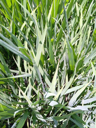

In [19]:
# look at one of the files
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [24]:
# Use fastcore's parallel to check the sizes for all the images
from fastcore.parallel import *

def f(o): 
    return PILImage.create(o).size

sizes = parallel(f, files, n_workers=8)
# value_counts(): Return a Series containing counts of unique values.
pd.Series(sizes).value_counts()


(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

Mostly of the same size (480x640), a few (640x480).

Need to resize each image to common dimensions first or fastai won't be able to create batches.

For now, will squish them to 480x480 images, then once they are in batches, do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by aug_transforms. 

We start out with small resized images, since we want to be able to iterate quickly.

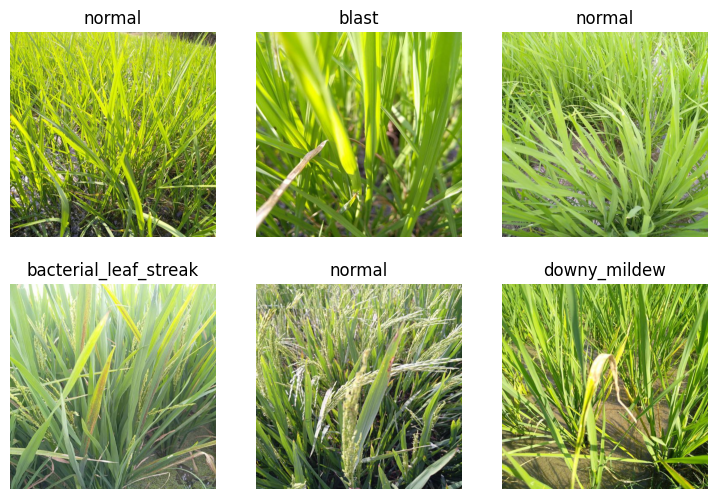

In [25]:
dls = ImageDataLoaders.from_folder(trn_path, 
                                   valid_pct=0.2, 
                                   seed=42, 
                                   item_tfms=Resize(480, method='squish'),
                                   bath_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

### Our first model

resnet26d - fastest resolution-independent model which gets into the top-15 lists there.


In [27]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0014454397605732083, slide=0.002511886414140463)

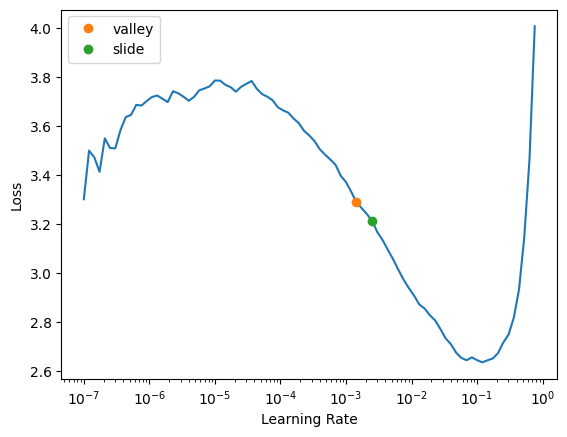

In [28]:
# what the learning rate finder shows?
learn.lr_find(suggest_funcs=(valley, slide))

In [29]:
# lr_find recommends rather conervative learning rates, to ensure that your model will train successfully.
# push to higher if can. 
# train a few epochs and see how it looks
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.235037,0.753451,0.233542,01:42


epoch,train_loss,valid_loss,error_rate,time
0,0.632922,0.422947,0.143681,02:14
1,0.276242,0.247032,0.078328,02:13
2,0.081671,0.210843,0.060548,02:13


### Submit to Kaggle

In [31]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


We need a CSV containing all the test images, in alphabetical order, and the predicted label for each one.

We can create the needed test set using fastai.

In [32]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [34]:
# get the probabilities of each class, and the index of the most likely class, 
# from this test set.
# The 2nd thing returned by get_preds are the targets, which are blank for a test set, 
# so we discard them.
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs


tensor([7, 8, 6,  ..., 8, 1, 5])

In [35]:
# These need to be mapped to the names of each of these diseases, 
# these names are stored by fastai automatically in the vocab.
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [37]:
# Can create and apply this mapping using pandas
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [38]:
# submission must be a CSV file
# save it and check the first few lines
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
